In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
import os
import joblib
from sklearn.metrics import r2_score
import matplotlib.dates as mdates

In [2]:
plt.rcParams["axes.unicode_minus"] = False

if platform.system() == "Darwin":  # macOS
    rc("font", family="AppleGothic")
elif platform.system() == "Windows":  # Windows
    font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc("font", family=font_name)
elif platform.system() == "Linux":  # Linux (Ubuntu, Docker 등)
    font_path = "fonts/NanumGothic.ttf"
    if not os.path.exists(font_path):
        st.error("NanumGothic.ttf 폰트 파일이 존재하지 않습니다. 'fonts' 폴더 내에 폰트 파일을 확인하세요.")
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc("font", family=font_name)

      연도   월      예측 수출량
0   2025   3  152.347565
1   2025   4  176.538455
2   2025   5  139.287410
3   2025   6  115.711597
4   2025   7  148.714910
5   2025   8  158.881536
6   2025   9  142.072010
7   2025  10  141.177979
8   2025  11  141.432887
9   2025  12  136.427094
10  2026   1  106.427314
11  2026   2  120.852236
12  2026   3  184.755127
13  2026   4  209.110777
14  2026   5  162.831098
15  2026   6  137.890117
16  2026   7  168.525053
17  2026   8  178.265484
18  2026   9  164.935123
19  2026  10  161.997280
20  2026  11  160.374682
21  2026  12  152.808177
22  2027   1  122.051713
23  2027   2  138.780106
24  2027   3  202.999904
25  2027   4  227.345964
26  2027   5  181.591797
27  2027   6  156.730276
28  2027   7  187.503064
29  2027   8  197.268301
30  2027   9  183.735435
31  2027  10  180.916552
32  2027  11  179.403235
33  2027  12  171.985777
34  2028   1  141.273356
35  2028   2  157.867674


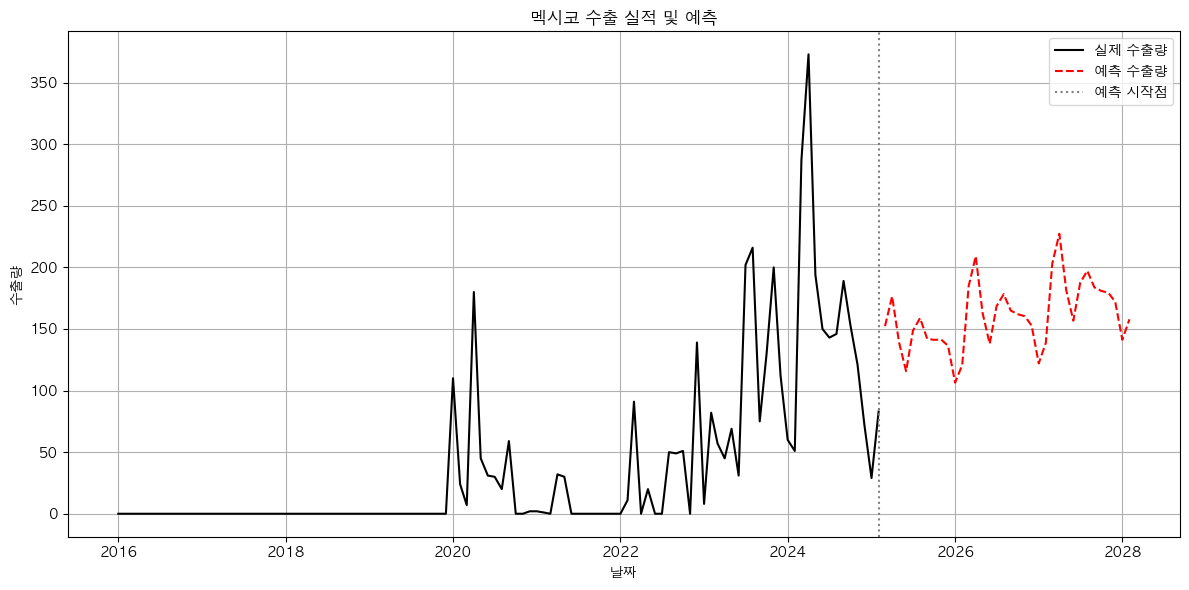

In [48]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

def prepare_region_series(df, region_name):
    region_data = df[df['지역명'] == region_name].iloc[:, 2:].T
    region_data.columns = ['y']
    region_data.index = pd.to_datetime(region_data.index)
    region_data = region_data.asfreq('MS')
    return region_data

def train_sarimax_model(series):
    # (p,d,q) = (1,1,1), (P,D,Q,s) = (1,1,1,12): 기본 계절성 모델
    model = SARIMAX(series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    fit_model = model.fit(disp=False)
    return fit_model

def forecast_future(fit_model, series, periods):
    last_date = series.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=periods, freq='MS')
    forecast = fit_model.get_forecast(steps=periods)
    forecast_mean = forecast.predicted_mean

    result = pd.DataFrame({
        '연도': future_dates.year,
        '월': future_dates.month,
        '예측 수출량': forecast_mean.values
    })
    return result


file_path = "../../data/processed/현대_지역별수출실적_전처리.csv"  # 본인 환경에 맞게 경로 설정
# region_name = "미국-북미"  # 입력받을 지역명
region_name = "멕시코"
forecast_months = 36   # 예측할 개월 수

df = load_data(file_path)
# df['지역명'] = df['지역명'].astype(str) + '-' + df['대륙'].astype(str).str.zfill(2)

# # 기존 컬럼 제거
# df = df.drop(columns=['대륙'])

# # '날짜' 컬럼을 맨 앞으로 이동
# cols = ['지역명'] + [col for col in df.columns if col != '지역명']
# df = df[cols]
region_series = prepare_region_series(df, region_name)
model = train_sarimax_model(region_series)
forecast_result = forecast_future(model, region_series, forecast_months)

print(forecast_result)

import matplotlib.pyplot as plt

def plot_series_with_forecast(series, forecast_result, region_name):
    # 실제값
    actual = series.copy()
    
    # 예측 날짜 구성
    forecast_index = pd.to_datetime(forecast_result['연도'].astype(str) + '-' + forecast_result['월'].astype(str))
    forecast_series = pd.Series(forecast_result['예측 수출량'].values, index=forecast_index)
    
    # 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(actual.index, actual['y'], label='실제 수출량', color='black')
    plt.plot(forecast_series.index, forecast_series.values, label='예측 수출량', color='red', linestyle='--')
    
    plt.axvline(x=actual.index[-1], color='gray', linestyle=':', label='예측 시작점')
    plt.title(f"{region_name} 수출 실적 및 예측")
    plt.xlabel("날짜")
    plt.ylabel("수출량")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_series_with_forecast(region_series, forecast_result, region_name)

In [26]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score, mean_squared_error

def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

def prepare_region_series(df, region_name):
    # 지역 필터링
    region_data = df[df['차량'] == region_name].iloc[:, 2:].T
    region_data.columns = ['y']
    region_data.index = pd.to_datetime(region_data.index)
    region_data = region_data.asfreq('MS')
    
    # 결측치 제거 + 타입 변환
    region_data['y'] = pd.to_numeric(region_data['y'], errors='coerce')  # 문자열 → 숫자
    region_data = region_data.dropna()  # 결측치 제거
    return region_data

def evaluate_model(series, test_size=6):
    # 데이터 정제
    series['y'] = pd.to_numeric(series['y'], errors='coerce')
    series = series.dropna()
    
    train = series[:-test_size]
    test = series[-test_size:]
    
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    fit_model = model.fit(disp=False)

    forecast = fit_model.get_forecast(steps=test_size)
    pred = forecast.predicted_mean

    r2 = r2_score(test, pred)
    rmse = mean_squared_error(test, pred, squared=False)

    return fit_model, r2, rmse

def forecast_future(fit_model, series, periods):
    last_date = series.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=periods, freq='MS')
    forecast = fit_model.get_forecast(steps=periods)
    forecast_mean = forecast.predicted_mean

    result = pd.DataFrame({
        '연도': future_dates.year,
        '월': future_dates.month,
        '예측 수출량': forecast_mean.values
    })
    return result

file_path = "../../data/processed/통합 문서6.csv"  # 실제 경로로 수정
region_name = "Sonata (LF)-승용차-내수"  # 거래 구분
forecast_months = 24   # 예측할 미래 개월 수

df = load_data(file_path)
df['차량'] = df['차종'].astype(str) + '-' + df['차량 유형'].astype(str).str.zfill(2) + '-' + df['거래 구분'].astype(str).str.zfill(2)

# 기존 컬럼 제거
df = df.drop(columns=['차종', '차량 유형', '거래 구분'])

# '날짜' 컬럼을 맨 앞으로 이동
cols = ['차량'] + [col for col in df.columns if col != '차량']
df = df[cols]

region_series = prepare_region_series(df, region_name)

# 학습 + 평가
model, r2, rmse = evaluate_model(region_series, test_size=60)

print(f"모델 평가 결과 (최근 6개월 기준)")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}\n")

# 미래 예측
forecast_result = forecast_future(model, region_series, forecast_months)
print("미래 예측 결과:")
print(forecast_result)

/opt/anaconda3/envs/hi/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/hi/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/hi/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


모델 평가 결과 (최근 6개월 기준)
R² Score: -426.0486
RMSE: 4881.78

미래 예측 결과:
      연도   월       예측 수출량
0   2025   3  6275.963903
1   2025   4  6424.664551
2   2025   5  6719.078219
3   2025   6  5910.336346
4   2025   7  5619.016101
5   2025   8  5165.299967
6   2025   9  5912.592791
7   2025  10  5555.501039
8   2025  11  5306.062561
9   2025  12  4340.142001
10  2026   1  5185.604247
11  2026   2  6228.916128
12  2026   3  6722.817047
13  2026   4  6878.861986
14  2026   5  7216.616899
15  2026   6  6283.974173
16  2026   7  5974.022983
17  2026   8  5598.982984
18  2026   9  6254.339914
19  2026  10  5958.072974
20  2026  11  5710.355000
21  2026  12  4694.402774
22  2027   1  5519.235701
23  2027   2  6624.996054


/opt/anaconda3/envs/hi/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/hi/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [20]:
df = pd.read_csv("../../data/processed/통합 문서6.csv")  # 실제 경로로 수정
df['차량'] = df['차종'].astype(str) + '-' + df['차량 유형'].astype(str).str.zfill(2) + '-' + df['거래 구분'].astype(str).str.zfill(2)

# 기존 컬럼 제거
df = df.drop(columns=['차종', '차량 유형', '거래 구분'])

# '날짜' 컬럼을 맨 앞으로 이동
cols = ['차량'] + [col for col in df.columns if col != '차량']
df = df[cols]

In [21]:
df

,차량,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,...,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02
0,Accent (RB)-승용차-내수,1016,1047,1735,1351,1292,1576,827,860,687,...,310,310,310,310,310,310,310,310,310,310
1,Avante (AD)-승용차-내수,6996,7932,8751,7628,8472,12363,6243,6756,5135,...,2263,2263,2263,2263,2263,2263,2263,2263,2263,2263
2,Avante (CN7)-승용차-내수,2425,2425,2425,2425,2425,2425,2425,2425,2425,...,5226,4196,3458,3450,3290,5411,4787,5766,4086,4658
3,Avante (CN7 HEV)-승용차-내수,272,272,272,272,272,272,272,272,272,...,432,468,415,435,396,517,496,617,1233,1445
4,Avante (CN7 N)-승용차-내수,67,67,67,67,67,67,67,67,67,...,135,142,102,67,67,67,169,79,144,193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,nan-nan-nan,45,45,45,45,45,45,45,45,45,...,45,152,45,45,45,45,45,45,45,45
434,nan-nan-nan,923,923,923,923,923,923,923,923,923,...,3042,2115,1633,1896,1068,2345,2490,2345,1984,2415
435,nan-nan-nan,148,148,148,148,148,148,148,148,148,...,472,295,278,320,278,374,303,399,370,444
436,nan-nan-nan,4727,4774,5277,4825,3819,4051,3501,2149,3486,...,2526,3370,2988,3490,3007,3552,3431,3364,2891,3593


In [ ]:
df.fillna